<div style="page-break-after: always;"></div>

![](https://github.com/zumaiaUOC/DL_PRA/blob/main/media/001.png?raw=1)![](https://github.com/zumaiaUOC/DL_PRA/blob/main/media/002.jpeg?raw=1)

**M2.875 Deep Learning**

Práctica                    Autor: Oscar Rojo Martín

# *Clasificador Neuronal para la detección de Glaucoma*

<div style="page-break-after: always;"></div>

1.  Presentación

El objetivo de esta práctica es aplicar los conocimientos adquiridos durante toda la asignatura en un caso clínico real. Para ello se dispondrá de una base de datos que contiene imágenes de ojos sanos y de otros afectados por glaucoma. El glaucoma es una patología que afecta al nervio óptico y cuyos orígenes son diversos, es la segunda causa de ceguera por detrás de la diabetes y los efectos en la pérdida de visión son irreversibles. Las causas que lo producen se pueden tratar si la patología es detectada a tiempo.

El objetivo final de esta práctica es, mediante los conocimientos adquiridos, proponer y entrenar un algoritmo que sea capaz de detectar adecuadamente ojos con glaucoma frente a otros sanos.


  
1. Definición del problema

Los algoritmos de reconocimiento de imágenes se están implementando en la práctica clínica, integrándose en ocasiones directamente en el hardware que se utiliza para la exploración (por ejemplo, en los ecógrafos). Este tipo de aproximación es lo que se propone en el siguiente artículo científico, el cual se utilizará como base para realizar esta práctica:

- Diaz-Pinto, A., Morales, S., Naranjo, V. et al. *CNNs for automatic glaucoma assessment using fundus images: an extensive validation*. BioMed Eng OnLine 18, 29 (2019). <https://doi.org/10.1186/s12938-019-0649-y>

En esta práctica se dispone de una serie de imágenes de casos reales. El objetivo es obtener un modelo eficaz para detectar de manera temprana esta patología, reduciendo, por lo tanto, el riesgo de ceguera.

La base de datos está formada por imágenes en color de 224x224 píxeles y se ha dividido en 10 particiones distintas que se usarán para aplicar un método de *cross validation* con el objetivo de minimizar errores estadísticos. Cada una de estas particiones, a su vez, contiene tres subconjuntos: *train*, *test* y *valid*. Las imágenes a su vez están etiquetadas de dos formas: *normal* o *abnormal*.


2. Función de evaluación

La función de evaluación que se utilizará a lo largo de la práctica será el **F1-score**.

6. Recursos

El conjunto de los datos del proyecto se puede encontrar en la dirección:

- <https://www.kaggle.com/datasets/jordidelatorreuoc/practica-dl-uoc-2022>



In [6]:
# Clono el repositorio de GitHub donde tengo guardado todos los archivos
# Esto último lo hago para ejecutar en google colab y no tener que hacerlo en
# un notebook... que no permite grandes cantidades procesos.
! git clone https://github.com/zumaiaUOC/DL_PRA.git
% cd /content/DL_PRA

Cloning into 'DL_PRA'...
remote: Enumerating objects: 1883, done.
remote: Counting objects: 100% (1883/1883), done.
remote: Compressing objects: 100% (1828/1828), done.
remote: Total 1883 (delta 67), reused 1858 (delta 53), pack-reused 0
Receiving objects: 100% (1883/1883), 27.51 MiB | 39.95 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Checking out files: 100% (17092/17092), done.
/content/DL_PRA


#### Importar librerias

In [7]:
#!pip install tf-nightly
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Import libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from numpy import asarray
import tensorflow as tf
import sklearn
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from sklearn.preprocessing import OneHotEncoder
import tensorflow_addons as tfa



In [9]:
# mount the drive
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
# go to the folder with the images
#% cd /content/drive/MyDrive/Colab Notebooks/DL-PRA

#### Cargar los datos desde kaggle usando API

In [11]:
# Import data from kaggle using Kaggle API
# ref.:https://medium.com/@jeff.daniel77/accessing-the-kaggle-com-api-with-jupyter-notebook-on-windows-d6f330bc6953
# ! kaggle datasets download -d jordidelatorreuoc/practica-dl-uoc-2022


In [12]:
# unzip to data folder
# ! unzip -o practica-dl-uoc-2022.zip -d data/

In [13]:
# drop practica-dl-uoc-2022.zip
# ! rm practica-dl-uoc-2022.zip

In [14]:
# Load data
base_dir = 'data/practica_DL_UOC_2022/'

# list folder in data/practica-dl-uoc-2022/
subfolder = os.listdir(base_dir)
print(subfolder)


['Fold2', 'Fold1', 'Fold6', 'Fold9', 'Fold0', 'Fold4', 'Fold7', 'Fold8', 'Fold3', 'Fold5']


In [15]:
train_dir = os.path.join(base_dir, subfolder[0]+'/train/')
test_dir = os.path.join(base_dir, subfolder[0]+'/test/')
valid_dir = os.path.join(base_dir, subfolder[0]+'/valid/')

# directorio con imagenes normal de entrenamiento
train_normal_dir = os.path.join(train_dir, 'normal/')
# directorio con imagenes abnormal de entrenamiento
train_anormal_dir = os.path.join(train_dir, 'abnormal/')

# directorio con imagenes normal de test
test_normal_dir = os.path.join(test_dir, 'normal/')
# directorio con imagenes abnormal de test
test_anormal_dir = os.path.join(test_dir, 'abnormal/')

# directorio con imagenes normal de validacion
valid_normal_dir = os.path.join(valid_dir, 'normal/')
# directorio con imagenes abnormal de validacion
valid_anormal_dir = os.path.join(valid_dir, 'abnormal/')


In [16]:
train_anormal_dir_list = os.listdir(train_anormal_dir)
print(train_anormal_dir_list[0])

SVbMJRCaiU.jpg


#### Crear dataframe

In [17]:
df_all = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
train_test_valid = ['train', 'test', 'valid']
for i in subfolder:
    for h in train_test_valid:
        for j in norm_abnorm:
            x_dir = os.path.join(base_dir, i+'/'+h+'/'+j+'/')
            x_dir_list = os.listdir(x_dir)
            # create a dataframe with fold, set, status, image and full_path
            df = pd.DataFrame(x_dir_list, columns=['image'])
            df['fold'] = i
            df['set'] = h
            df['status'] = j
            df['full_path'] = df['image'].apply(lambda x: os.path.join(x_dir, x))
            df_all = pd.concat([df_all, df])

df_all 

,image,fold,set,status,full_path
0,ZGhDUUoSnQ.jpg,Fold2,train,normal,data/practica_DL_UOC_2022/Fold2/train/normal/Z...
1,RKSPwzPSFk.jpg,Fold2,train,normal,data/practica_DL_UOC_2022/Fold2/train/normal/R...
2,XwVsIgNJuQ.jpg,Fold2,train,normal,data/practica_DL_UOC_2022/Fold2/train/normal/X...
3,oHOGyQJaPn.jpg,Fold2,train,normal,data/practica_DL_UOC_2022/Fold2/train/normal/o...
4,bAsfjYndBA.jpg,Fold2,train,normal,data/practica_DL_UOC_2022/Fold2/train/normal/b...
...,...,...,...,...,...
78,vGppgciGaM.jpg,Fold5,valid,abnormal,data/practica_DL_UOC_2022/Fold5/valid/abnormal...
79,bTyTIvwzLf.jpg,Fold5,valid,abnormal,data/practica_DL_UOC_2022/Fold5/valid/abnormal...
80,RcutCZHyYw.jpg,Fold5,valid,abnormal,data/practica_DL_UOC_2022/Fold5/valid/abnormal...
81,bSSXVNtAgp.jpg,Fold5,valid,abnormal,data/practica_DL_UOC_2022/Fold5/valid/abnormal...


In [18]:
# Comprobar que el numero de imagenes es correcto

In [19]:
df_all_train = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        train_dir = os.path.join(base_dir, i+'/train/')
        train_dir_dir = os.path.join(train_dir, j+'/')
        train_dir_list = os.listdir(train_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_train = pd.DataFrame({'fold': [i]*len(train_dir_list),
                                    'set': [j]*len(train_dir_list),
                                    'status': [j]*len(train_dir_list),
                                    'image': train_dir_list,
                                    'full_path': [os.path.join(train_dir_dir, x) for x in train_dir_list]})
        df_all_train = pd.concat([df_all_train, df_train])

df_all_train.shape
    

(13790, 5)

In [20]:
df_all_test = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        test_dir = os.path.join(base_dir, i+'/test/')
        test_dir_dir = os.path.join(test_dir, j+'/')
        test_dir_list = os.listdir(test_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_test = pd.DataFrame({'fold': [i]*len(test_dir_list),
                                'set': [j]*len(test_dir_list),
                                'status': [j]*len(test_dir_list),
                                'image': test_dir_list,
                                'full_path': [os.path.join(test_dir_dir, x) for x in test_dir_list]})
        df_all_test = pd.concat([df_all_test, df_test])

df_all_test.shape


(1740, 5)

In [21]:
df_all_valid = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        valid_dir = os.path.join(base_dir, i+'/valid/')
        valid_dir_dir = os.path.join(valid_dir, j+'/')
        valid_dir_list = os.listdir(valid_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_valid = pd.DataFrame({'fold': [i]*len(valid_dir_list),
                                 'set': [j]*len(valid_dir_list),
                                 'status': [j]*len(valid_dir_list),
                                 'image': valid_dir_list,
                                 'full_path': [os.path.join(valid_dir_dir, x) for x in valid_dir_list]})
        df_all_valid = pd.concat([df_all_valid, df_valid])

df_all_valid.shape


(1540, 5)



# **Sección 1. Análisis Exploratorio de los datos (1,5 puntos)**

Realizar un análisis exploratorio de los datos proporcionados, tanto en formato numérico como gráfico, donde se recoja la información relevante del conjunto de datos proporcionado.


Dimensión: (17070, 5)


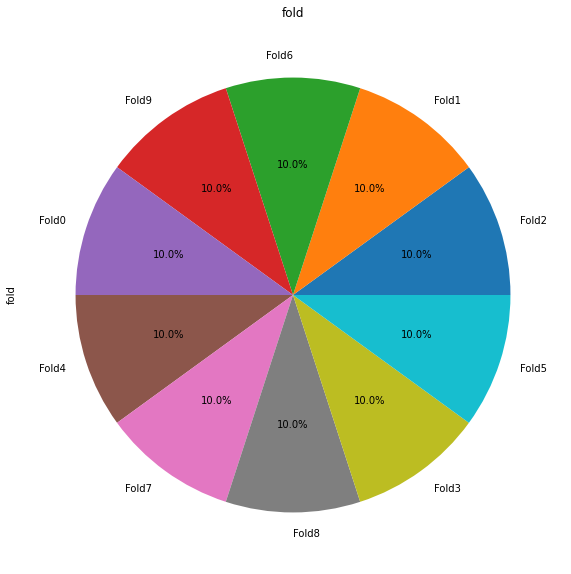

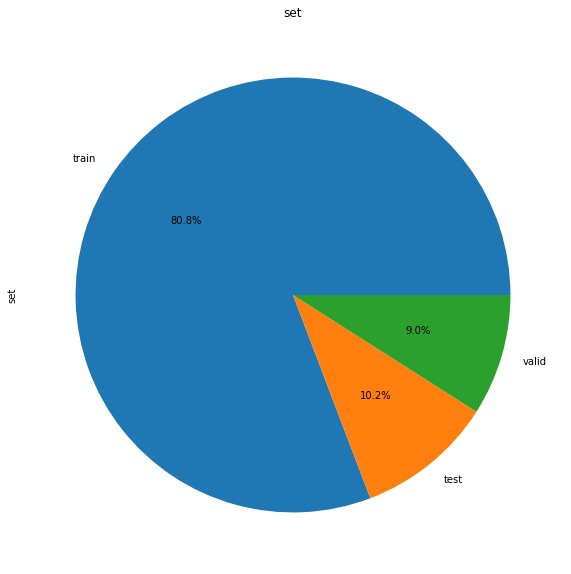

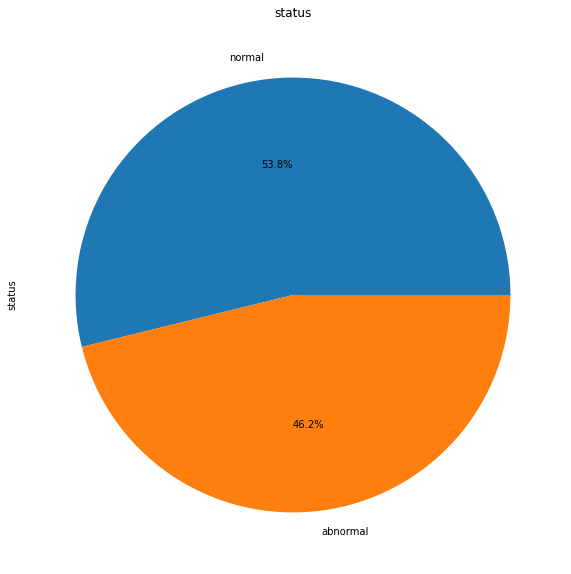

In [22]:
# Dimensión
print("Dimensión: {}".format(df_all.shape))

# list of columns
column_list = ['fold', 'set', 'status']   



# pie chart 
for i in column_list:
    df_all[i].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10))
    plt.title(i)
    plt.show()




In [23]:
# load images
def load_image(path):
    image = Image.open(path)
    image = image.resize((224, 224))
    image = np.array(image)
    return image

load_image(df_all.iloc[0]['full_path'])


array([[[193, 130,  87],
        [194, 129,  87],
        [195, 128,  86],
        ...,
        [255, 141,  71],
        [255, 139,  70],
        [255, 139,  70]],

       [[194, 129,  87],
        [194, 129,  87],
        [195, 128,  86],
        ...,
        [255, 141,  71],
        [254, 140,  70],
        [254, 140,  70]],

       [[194, 129,  87],
        [196, 129,  87],
        [195, 128,  86],
        ...,
        [254, 141,  71],
        [254, 141,  71],
        [253, 140,  70]],

       ...,

       [[211, 124,  79],
        [211, 122,  82],
        [211, 117,  83],
        ...,
        [249, 127,  64],
        [248, 125,  65],
        [248, 125,  65]],

       [[207, 122,  81],
        [207, 119,  81],
        [208, 115,  82],
        ...,
        [246, 128,  64],
        [244, 126,  64],
        [243, 125,  64]],

       [[205, 120,  81],
        [205, 117,  81],
        [206, 113,  82],
        ...,
        [244, 129,  64],
        [242, 127,  64],
        [242, 124,  63]]

In [27]:
df_all_normal = df_all[df_all['status'] == 'normal']
df_all_abnormal = df_all[df_all['status'] == 'abnormal']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen Normal
JPEG
RGB
(224, 224)
Mean: 151.364
Min: 58.000, Max: 255.000
Mean: 0.000
Min: -93.364, Max: 103.636
Data Type: float64
Min: -93.364, Max: 103.636
pixel mean =  -3.953369e-09
Min: -0.366, Max: 0.406


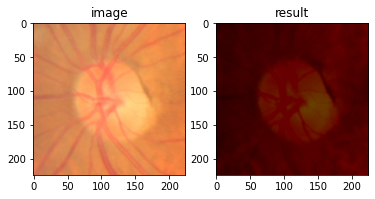

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen Abnormal
JPEG
RGB
(224, 224)
Mean: 113.583
Min: 23.000, Max: 255.000
Mean: 0.000
Min: -90.583, Max: 141.417
Data Type: float64
Min: -90.583, Max: 141.417
pixel mean =  3.446527e-09
Min: -0.355, Max: 0.555


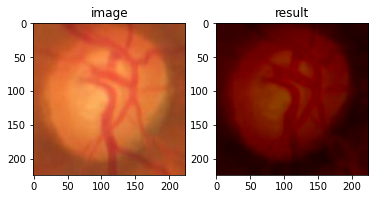

In [28]:
def image_info(path):
    image = Image.open(path)
    print(image.format)
    print(image.mode)
    print(image.size)
    pixels = asarray(image)
    # global centering


    # calculate global mean
    mean = pixels.mean()
    print('Mean: %.3f' % mean)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    # global centering of pixels
    pixels = pixels - mean
    # confirm it had the desired effect
    mean = pixels.mean()
    print('Mean: %.3f' % mean)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    #print(pixels)


    # example of pixel normalization
    # confirm pixel range is 0-255
    print('Data Type: %s' % pixels.dtype)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # normalize to the range 0-1
    pixels /= 255.0
    mean = pixels.mean()
    print('pixel mean = ', mean)

    # confirm the normalization
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

    # show the image
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.imshow(image)
    ax0.axis('on')
    ax0.set_title('image')
    ax1.imshow(pixels)
    ax1.axis('on')
    ax1.set_title('result')
    plt.show()
    
print('Imagen Normal')
image_info(df_all_normal.iloc[0]['full_path'])
print('Imagen Abnormal')
image_info(df_all_abnormal.iloc[0]['full_path'])


In [29]:
def imagen(path):
    image = Image.open(path)
    pixels = asarray(image) # convert image to numpy array
    # calculate global mean
    mean = pixels.mean()
    # global centering of pixels
    pixels = pixels - mean
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # normalize to the range 0-1
    pixels /= 255.0
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 14))
    ax0.imshow(image)
    ax0.axis('on')
    ax0.set_title('original image', fontsize=20)
    ax1.imshow(pixels)
    ax1.axis('on')
    ax1.set_title('result', fontsize=20)
    plt.show()

# imagen(df_all.iloc[0]['full_path'])

##### ojo sano:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


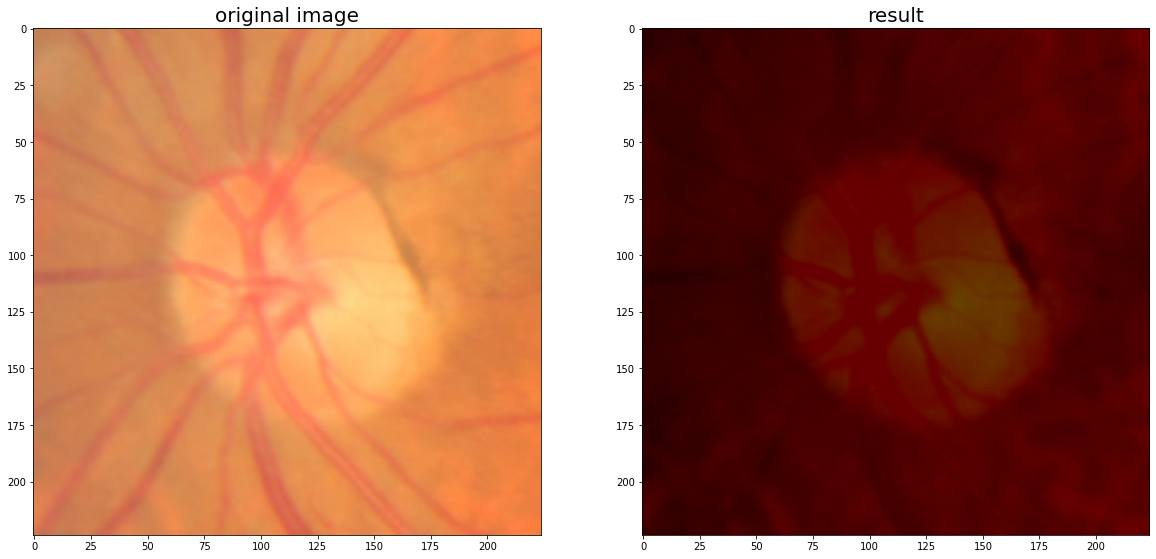

In [30]:
# filter df_all status = normal
df_all_normal = df_all[df_all['status'] == 'normal']
imagen(df_all_normal.iloc[0]['full_path'])

##### ojo con Glaucoma:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


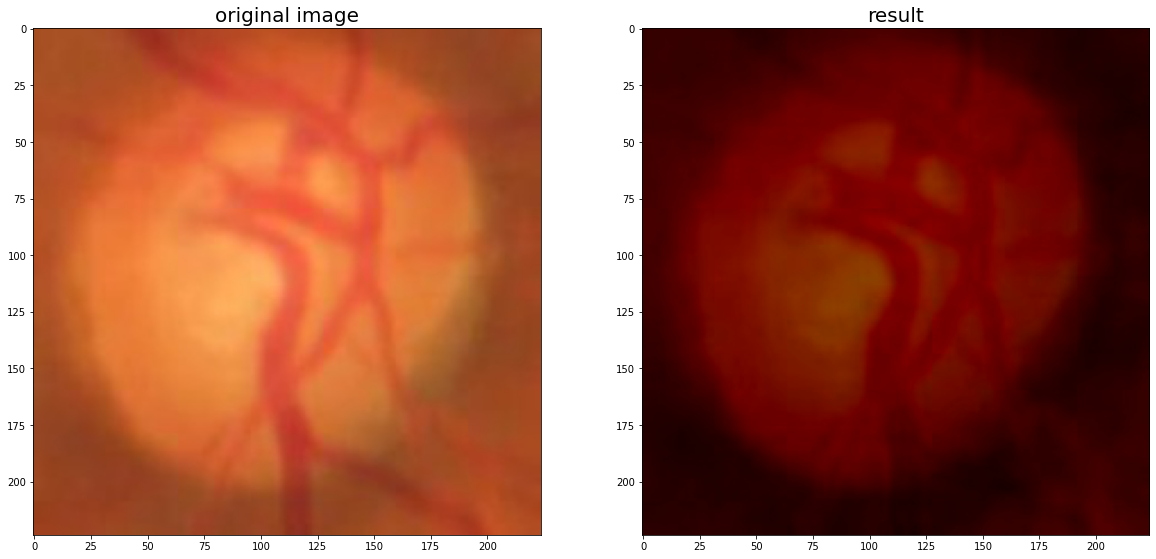

In [31]:
# filter df_all status = abnormal
df_all_abnormal = df_all[df_all['status'] == 'abnormal']
imagen(df_all_abnormal.iloc[0]['full_path'])


# **Sección 2. Entrenamiento de una red neuronal sobre una única partición (4 puntos)**

En esta primera parte se hará un entrenamiento únicamente sobre el **fold0**. Esto nos permitirá obtener conclusiones preliminares en un plazo razonable de tiempo, antes de ejecutar un entrenamiento completo empleando *cross validation* (ver sección 3). Para ello se deben proponer y comparar 5 aproximaciones distintas:

- Las 3 primeras configuraciones se deben implementar en un modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
  - En la primera configuración se entrena el modelo congelando todas las capas menos las que se han añadido al final (**modelo 1**).
  - En una segunda configuración, a partir de los pesos encontrados para el modelo 1, se entrena descongelando las últimas 20 capas, pero dejando las capas de *BatchNorm* congeladas (**modelo 2**).
  - En la tercera configuración, a partir de los pesos del modelo 2, se descongelan todas las capas y se entrena la red en su totalidad (**modelo 3**).
- Entrenar dos configuraciones, modelos o arquitecturas adicionales, que se pueden escoger libremente (**modelo 4** y **modelo 5**).

En todos los casos, se debe indicar y justificar:

- Elegir la época e hiperparámetros que mejor resultados hayan proporcionado sobre el conjunto de validación durante el entrenamiento.
- Proporcionar y discutir los resultados sobre el conjunto de test.
- Obtener la matriz de confusión, y discutir los resultados teniendo en cuenta los objetivos del problema.


In [33]:
df_all

,image,fold,set,status,full_path
0,ZGhDUUoSnQ.jpg,Fold2,train,normal,data/practica_DL_UOC_2022/Fold2/train/normal/Z...
1,RKSPwzPSFk.jpg,Fold2,train,normal,data/practica_DL_UOC_2022/Fold2/train/normal/R...
2,XwVsIgNJuQ.jpg,Fold2,train,normal,data/practica_DL_UOC_2022/Fold2/train/normal/X...
3,oHOGyQJaPn.jpg,Fold2,train,normal,data/practica_DL_UOC_2022/Fold2/train/normal/o...
4,bAsfjYndBA.jpg,Fold2,train,normal,data/practica_DL_UOC_2022/Fold2/train/normal/b...
...,...,...,...,...,...
78,vGppgciGaM.jpg,Fold5,valid,abnormal,data/practica_DL_UOC_2022/Fold5/valid/abnormal...
79,bTyTIvwzLf.jpg,Fold5,valid,abnormal,data/practica_DL_UOC_2022/Fold5/valid/abnormal...
80,RcutCZHyYw.jpg,Fold5,valid,abnormal,data/practica_DL_UOC_2022/Fold5/valid/abnormal...
81,bSSXVNtAgp.jpg,Fold5,valid,abnormal,data/practica_DL_UOC_2022/Fold5/valid/abnormal...


In [34]:
# save df_all as csv
df_all.to_csv('data/df_all.csv', index=False)

In [35]:
# Filter data_all by fold
df_fold_0 = df_all[df_all['fold'] == 'Fold0']
df_fold_0.head()

df_fold_0_train = df_fold_0[df_fold_0['set'] == 'train']
df_fold_0_test = df_fold_0[df_fold_0['set'] == 'test']
df_fold_0_valid = df_fold_0[df_fold_0['set'] == 'valid']
y_train = pd.get_dummies(df_fold_0_train['status'])
y_valid = pd.get_dummies(df_fold_0_valid['status'])
y_test = pd.get_dummies(df_fold_0_test['status'])

In [ ]:
# convert df_fold_0_train['status'] to one-hot encoding
#df_fold_0_train['status'] = df_fold_0_train['status'].map({'normal': 0, 'abnormal': 1})
#df_fold_0_valid['status'] = df_fold_0_valid['status'].map({'normal': 0, 'abnormal': 1})
#df_fold_0_test['status'] = df_fold_0_test['status'].map({'normal': 0, 'abnormal': 1})


In [36]:
# convert df_fold_0_train to a numpy array
X_train = np.array([load_image(x) for x in df_fold_0_train['full_path']])
#y_train = np.array(df_fold_0_train['status'])
y_train = np.array(y_train)

# get max and min values of X_train
X_train_min = X_train.min()
X_train_max = X_train.max()
# normalize X_train
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)


print("X_train :",X_train.shape)
print("y_train :",y_train.shape)

X_train : (1379, 224, 224, 3)
y_train : (1379, 2)


In [37]:
# convert df_fold_0_train to a numpy array
x_valid = np.array([load_image(x) for x in df_fold_0_valid['full_path']])
#y_valid = np.array(df_fold_0_valid['status'])
y_valid = np.array(y_valid)
x_valid_min = x_valid.min()
print("min_valid:", x_valid_min)
x_valid_max = x_valid.max()
print("max_valid:", x_valid_max)
# normalize X_train
x_valid = (x_valid - x_valid_min) / (x_valid_max - x_valid_min)

min_valid: 0
max_valid: 255


In [38]:
# convert df_fold_0_train to a numpy array
x_test = np.array([load_image(x) for x in df_fold_0_test['full_path']])
#y_test = np.array(df_fold_0_test['status'])
y_text = np.array(y_test)
x_test_min = x_test.min()
print("min_valid:", x_test_min)
x_test_max = x_test.max()
print("max_test:", x_test_max)
# normalize X_train
x_test = (x_test - x_test_min) / (x_test_max - x_test_min)

min_valid: 0
max_test: 255


### Modelo 1
Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
Se entrena el modelo congelando todas las capas menos las que se han añadido al final 

In [39]:
def model_builder(n_classes, shape, optimizador, lr):
    inputs = layers.Input(shape=shape, name='input')
    # base model EfficientNetB0 with pre-trained weights imagenet
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    # freeze all layers of base model
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model(inputs)

    # Add Global Average Pooling 2D
    x = layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)
    # Add BatchNormalization
    x = layers.BatchNormalization(name='BatchNormalization')(x)
    # add Dropout with 0.2 probability
    x = layers.Dropout(0.2, name='Dropout')(x)
    # unfreeze last layer of base model
    base_model.layers[-1].trainable = True
    # fully connected layer with softmax activation
    output = layers.Dense(n_classes, activation='softmax', name='output')(x)
    # create model
    model = tf.keras.Model(inputs=inputs, outputs=output)
    # compile model
    #model.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=optimizador, loss='categorical_crossentropy',
                  metrics=tfa.metrics.F1Score(num_classes=n_classes, average='macro'))
    # summarize model
    model.summary()
    return model

model_builder(2, (224, 224, 3), 'Adam', 0.0001)



16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 BatchNormalization (BatchNo  (None, 1280)             5120      
 rmalization)                                                    
                                                                 
 Dropout (Dropout)           (None, 1280)              0         
                                                              

In [45]:

def model_1_build(n_classes, shape, optimizer, lr):
    #print('Number of classes:', n_classes, '\nShape:', shape, '\nOptimizer:', optimizer, '\nLearning rate:', lr)
    inputs = layers.Input(shape=shape, name='inputs')
    # base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False, weights='imagenet')

    # Freeze layers
    base_model.trainable = False
    x = base_model(inputs, training=False)

    # Add new layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(n_classes, activation='sigmoid', name='outputs')(x)

    if optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    # set metrics f1_score
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
    metrics=tfa.metrics.F1Score(num_classes=n_classes, average='macro'))
    

    #model.summary()

    return model


In [42]:
model=model_1_build(2, (224, 224, 3), 'Adam', 0.0001)
model_1=model_1_build(2, (224, 224, 3), 'Adam', 0.0001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 outputs (Dense)             (None, 2)                 2562

In [46]:

# choose the epoch and hyperparameters for the model over validation set during training
params = {
    'epochs': [10, 50, 80, 100],
    'optimizer': ['Adam', 'SGD'],
    'lr': [0.0001, 0.001, 0.01, 0.1]
}


In [ ]:
# fit the model
def fit_model(model, X_train, y_train, x_valid, y_valid, params):
    # create a dataframe to store the results
    results = pd.DataFrame(columns=['epochs', 'optimizer', 'lr', 'loss', 'accuracy'])

    # loop over epochs, optimizers and learning rates
    for epochs in params['epochs']:
        for optimizer in params['optimizer']:
            for lr in params['lr']:
                print('Epochs:', epochs, '\tOptimizer:', optimizer, '\tLearning rate:', lr)
                # create a new model
                model = model_1_build(n_classes=2, shape=X_train.shape[1:], optimizer=optimizer, lr=lr)

                # train the model
                history = model.fit(X_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, verbose=0)

                # evaluate the model
                loss, accuracy = model.evaluate(x_valid, y_valid, verbose=0)

                # store the results
                results = results.append({'epochs': epochs, 'optimizer': optimizer, 'lr': lr, 'loss': loss, 'accuracy': accuracy}, ignore_index=True)
                

    # save the results
    results.to_csv('data/results.csv', index=False)

    imprimir = results

    return imprimir

fit_model(model, X_train, y_train, x_valid, y_valid, params)

Epochs: 1 	Optimizer: Adam 	Learning rate: 0.0001
Epochs: 1 	Optimizer: Adam 	Learning rate: 0.001
Epochs: 1 	Optimizer: Adam 	Learning rate: 0.01
Epochs: 1 	Optimizer: Adam 	Learning rate: 0.1
Epochs: 1 	Optimizer: SGD 	Learning rate: 0.0001
Epochs: 1 	Optimizer: SGD 	Learning rate: 0.001
Epochs: 1 	Optimizer: SGD 	Learning rate: 0.01
Epochs: 1 	Optimizer: SGD 	Learning rate: 0.1
Epochs: 2 	Optimizer: Adam 	Learning rate: 0.0001
Epochs: 2 	Optimizer: Adam 	Learning rate: 0.001
Epochs: 2 	Optimizer: Adam 	Learning rate: 0.01
Epochs: 2 	Optimizer: Adam 	Learning rate: 0.1
Epochs: 2 	Optimizer: SGD 	Learning rate: 0.0001
Epochs: 2 	Optimizer: SGD 	Learning rate: 0.001
Epochs: 2 	Optimizer: SGD 	Learning rate: 0.01
Epochs: 2 	Optimizer: SGD 	Learning rate: 0.1
Epochs: 5 	Optimizer: Adam 	Learning rate: 0.0001
Epochs: 5 	Optimizer: Adam 	Learning rate: 0.001
Epochs: 5 	Optimizer: Adam 	Learning rate: 0.01
Epochs: 5 	Optimizer: Adam 	Learning rate: 0.1
Epochs: 5 	Optimizer: SGD 	Learning ra

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

In [ ]:
predictions = model_1.predict(x_test)
y_pred = np.argmax(predictions, axis=1)
y_pred = np.append(y_pred,y_pred)
y_pred

In [ ]:

y_true = y_test
y_true = LabelBinarizer().fit_transform(y_true)
y_true = y_true.flatten()
y_true

In [ ]:
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

df_conf_matrix = pd.DataFrame(conf_matrix)


sns.heatmap(df_conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


In [ ]:
#! echo 0 | sudo tee -a /sys/bus/pci/devices/NNNNN/numa_node

In [ ]:
# Model 1
# Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*
def creador_modelo(n_classes, shape, optimizer, lr):
    prev_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=shape)
    model_1 = models.Sequential()
    # freeze layers
    for layer in model_1.layers:
        layer.trainable = False
    model_1.add(prev_model)
    # sustituir la capa de clasificación por una capa GlobalAveragePooling2D
    model_1.add(layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D'))
    # layer of "BatchNormalization"
    model_1.add(layers.BatchNormalization())
    # layer of "Dropout"
    model_1.add(layers.Dropout(0.2))
    # layer of Fully Connected
    model_1.layers[-1].trainable = True
    model_1.add(layers.Dense(n_classes, activation='sigmoid'))
    # compile the model
    if optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    #model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model_1.summary()


    # compile the model
    model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                            loss='binary_crossentropy',
                            metrics=tfa.metrics.F1Score(num_classes=n_classes, average='macro'),
                            run_eagerly=True)
    # freeze layers
    for layer in model_1.layers:
        layer.trainable = False
    # save the model
    model_1.save('data/models/model_1.h5')

    # save weights
    model_1.save_weights('data/models/model_1_weights.h5')

    return model_1


In [ ]:
# create parameters for the model
params = {
    'epochs': [1, 2, 5, 10],
    'optimizer': ['Adam', 'SGD'],
    'lr': [0.0001, 0.001, 0.01, 0.1]
}

In [ ]:

creador_modelo(2, (224, 224, 3), 'Adam', 0.0001)

In [ ]:
train = X_train
batch_size = 32
valid = x_valid
steps_per_epoch = train // batch_size
validation_steps = valid // batch_size
epoch = 10
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
]


In [ ]:
# train the model
history_1 = model_1.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_valid,y_valid),
                        callbacks=callbacks,
                        verbose=1)
                        

In [ ]:
# get f1 score
from sklearn.metrics import f1_score

# get f1 from the history
f1_1 = f1_score(y_true=y_test, y_pred=model_1.predict(x_test), average='macro')
f1_1

In [ ]:
model_1.evaluate(X_train, y_train, batch_size=10)

In [ ]:
model_1.evaluate(x_valid, y_valid, batch_size=10)

In [ ]:
model_1.evaluate(x_test, y_test)

In [ ]:
predictions = model_1.predict_generator(x_test)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = y_test.classes
class_labels = list(y_test.class_indices.keys())  

In [ ]:
# plot the training history
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



In [ ]:
# plot accuracy and loss
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['loss'])
plt.title('model accuracy')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


In [ ]:
# plot the training history
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [ ]:
batch_normalization,
def model_1_biuid(n_classes, shape, optimizer, lr):
  print('Número clases: ', n_classes, '\nshape', shape, 'ªnLearning rate ', lr)
  inputs = layers.Input(shape = shape, name='inputLayer')
  base_model = EfficientNetB0(weights='imagenet', include_top = False)

  #Congelamos capas
  base_model.trainable=False
  x = base_model(inputs, training = False)

  #Añadimos capas
  x = Global AveragePooling2D()(x)
  x = batch_normalization(x)
  x = Dropout(0.2)(x)

  #Compilamos
  model = Model(inputs, outputs)
  model.compile(loss = 'categorical_crossentropy', 
                optimizer=optimizer(learning_rate=lr), 
                metrics=['acc'])
  
  return model


In [ ]:
def build_generator(data_path, img_size=(32,32), batch_size=32):
    print('[Build_generators] dir', data_path, 'img:', img_size, 'batch_size', batch_size)
  # initialize the training data augmentation object
    train_aug = tf.keras.preprocessiong.image.ImageDataGenerator(
        rescale=1.0/255,
        rotation_range = 20,
        zoom_range =0.05,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        horizonal_flip=True,
        fill_mode='nearest')
  
  # initialize the validation (and testing) data augmentation object
    val_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)



    # initialize the training generator
    train_path = os.path.join(data_path, 'train')
    print('[build_generators] train', train_path)
    train_gen = train_aug.flow_from_directory(
        directory = train_path, 
        class_mode = "categorical",
        target_size =  img_size,
        #color_mode="rgb"
        shuffle=True,
        batch_size = batch_size
    )

    val_gen = val_aug.flow_from_directory(
            directory = os.path.join(data_path, 'valid'),
            class_mode = "categorical",
            target_size = img_size,
            #color_mode="rgb"
            shuffle=True,
            batch_size = batch_size
        )


    # initialize the validation generator
    val_path = os.path.join(data_path, 'valid')
    print('[build_generators] test:', test_path)
    test_gen = val_aug.flow_from_directory(
        directory= test_path,
        class_mode = 'categorical',
        target_size = img_size,
        color_mode ='rbg',
        shuffle = False,
        batch_size = batch_size
    )

    return train_gen, val_gen, test_gen

In [ ]:
build_generator('data/practica_DL_UOC_2022/')

In [ ]:
tf.random.set_seed(42)
def build_model(num_classes, shape, lr=1e-4):
  print('[build-model] num_classes:', num_classes, 'shape:', shape, 'lr', lr)
  inputs = tf.keras.layers.Input(shape=shape, name='input_layer')

  basel_model = tf.keras.aplications.efficientnet.EfficientNetB0(
      include_top=False, weights='imagenet')
  
  # Freeze the pretraineed weights
  base_model.trainable = False
  x = base_model(inputs, training = False)

  # Rebuild top
  x = tf.keras.layer.GlobalAveragePolling2D(name="avg_pool")(x)
  x = tf.keras.layer.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)

  # compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")

  optimizer = tf.keras.optimizers.Adam()
  model.compile(
      optimizer=optimizer,
      loss="categorical_crossentropy",
      metrics=['accuracy']
  )
  return model

In [ ]:
from keras.backend import shape
build_model(2, 32)

In [ ]:
from gc import callbacks
callbacks=[reduce_lr]

In [ ]:
# Fit
total_train = train_gen.samples
total_val = val_gen.samples
total_test =test_gen.samples

steps_per_epoch = total_train // batch_size
validation_steps = total_val // batch_size

print('[train] total_train:', total_train, 'total_val:', total_Val, 'total_test:', total_test, 'epochs:', epochs)
print('[train] steps_per_epoch:', steps_per_epoch)
print('[train] validation_steps:', validtion_steps)
H = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data_val=gen,
    validation_steps=validation_steps,
    epochs=epochs #,callsbacks=callbacks
)

### Modelo 2
modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
 A partir de los pesos encontrados para el modelo 1, se entrena descongelando las últimas 20 capas, pero dejando las capas de *BatchNorm* congeladas  

In [ ]:
shape = (224, 224, 3)
num_classes = 2

In [ ]:
head_model = tf.keras.applications.EfficientNetB0(input_shape=shape, include_top=False, weights='imagenet')
# Freeze all layers
head_model.trainable = False
inputs = tf.keras.layers.Input(shape=shape)
# añadimos capas
head_model = head_model(inputs, training=True)
# GlobalMaxPooling2D
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = tf.keras.layers.BatchNormalization()(head_model)
head_model = Dropout(0.2)(head_model)
outputs = Dense(num_classes, activation='softmax')(head_model)
model2 = tf.keras.Model(inputs, outputs)

# cargamos los pesos del modelo 1
model2.load_weights('data/models/model_1_weights.h5',
                    skip_mismatch=False, by_name=True)

# entrenamos las 20 últimas capas
for layer in model2.layers[:20]:
  layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
lr = 1e-4
epochs = 10
batch_size = 32
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
]

# Compile
model2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

In [ ]:
# freeze layers
for layer in model2.layers:
  layer.trainable = False

# save model2
model2.save('data/models/model_2.h5')
# save weights of model2
model2.save_weights('data/models/model_2_weights.h5')


In [ ]:

# Fit
H_model_2 = model2.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)



In [ ]:
# plot the training history
plt.plot(H_model_2.history['accuracy'])
plt.plot(H_model_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# plot accuracy and loss
plt.plot(H_model_2.history['accuracy'])
plt.plot(H_model_2.history['loss'])
plt.title('model accuracy')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# plot the training history
plt.plot(H_model_2.history['loss'])
plt.plot(H_model_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

### Modelo 3
Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
A partir de los pesos del modelo 2, se descongelan todas las capas y se entrena la red en su totalidad 

In [ ]:
head_model = tf.keras.applications.EfficientNetB0(
    input_shape=shape, include_top=False, weights='imagenet')
# Freeze all layers
head_model.trainable = False
inputs = tf.keras.layers.Input(shape=shape)
# añadimos capas
head_model = head_model(inputs, training=True)
# GlobalMaxPooling2D
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = tf.keras.layers.BatchNormalization()(head_model)
head_model = Dropout(0.2)(head_model)
outputs = Dense(num_classes, activation='softmax')(head_model)
model3 = tf.keras.Model(inputs, outputs)

# save model3
model3.save('data/models/model_3.h5')

# cargamos los pesos del modelo 2
model3.load_weights('data/models/model_2_weights.h5', skip_mismatch=False, by_name=True)
# descongelamos todas las capas
model3.trainable = True

# Compile
model3.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

h_model_3 = model3.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)


In [ ]:
# plot the training history
plt.plot(h_model_3.history['accuracy'])
plt.plot(h_model_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# plot accuracy and loss
plt.plot(h_model_3.history['accuracy'])
plt.plot(h_model_3.history['loss'])
plt.title('model accuracy')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# plot the training history
plt.plot(h_model_3.history['loss'])
plt.plot(h_model_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

### Modelo 4

Una capa convulucional

In [ ]:
# CNN model of one convolutional layer
def build_model_4(num_classes, input_shape):
    # input
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # convolutional layer
    x = tf.keras.layers.Conv2D(
        32, (3, 3), activation='relu', padding='same', name='conv1')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout1')(x)
    
    # flatten
    x = tf.keras.layers.Flatten()(x)
    
    # dense layer
    x = tf.keras.layers.Dense(128, activation='relu', name='dense1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout2')(x)
    
    # output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)
    
    # compile
    model = tf.keras.Model(inputs, outputs, name="CNN")
    
    # get the model summary
    optimizer = tf.keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    # save the model
    model.save('data/models/model_4.h5')
    # save the weights
    model.save_weights('data/models/model_4_weights.h5')

    return model

model_4 = build_model_4(num_classes, shape)
# Fit
H_model_4 = model_4.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)


In [ ]:
# plot the training history
plt.plot(H_model_4.history['accuracy'])
plt.plot(H_model_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# plot accuracy and loss
plt.plot(H_model_4.history['accuracy'])
plt.plot(H_model_4.history['loss'])
plt.title('model accuracy')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# plot the training history
plt.plot(H_model_4.history['loss'])
plt.plot(H_model_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

### Modelo 5

Un modelo sencillo

In [ ]:
# get a simply model
def build_model_5(num_classes, input_shape):
    # input
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # flatten
    x = tf.keras.layers.Flatten()(inputs)
    
    # dense layer
    x = tf.keras.layers.Dense(128, activation='relu', name='dense1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout2')(x)
    
    # output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)
    
    # compile
    model = tf.keras.Model(inputs, outputs, name="CNN")
    
    # get the model summary
    optimizer = tf.keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )
    # get the model summary
    model.summary()

    # save the model
    model.save('data/models/model_5_weights.h5')
    # save the weights
    model.save_weights('data/models/model_5_weights.h5')

    return model

model_5 = build_model_5(num_classes, shape)

In [ ]:
# Fit
H_model_5 = model_5.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)

In [ ]:
# plot the training history
plt.plot(H_model_5.history['accuracy'])
plt.plot(H_model_5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# plot accuracy and loss
plt.plot(H_model_5.history['accuracy'])
plt.plot(H_model_5.history['loss'])
plt.title('model accuracy')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# plot the training history
plt.plot(H_model_5.history['loss'])
plt.plot(H_model_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [ ]:
# get predictions
predictions = model_5.predict(x_test)

# get f1 score
f1_score(y_test, predictions)

# get accuracy
accuracy_score(y_test, predictions)
# get confusion matrix
confusion_matrix(y_test, predictions)


In [ ]:
# plot the training history
plt.plot(history_1.history['loss'], label='model_1')
plt.plot(H_model_2.history['loss'], label='model_2')
plt.plot(h_model_3.history['loss'], label='model_3')
plt.plot(H_model_4.history['loss'], label='model_4')
plt.plot(H_model_5.history['loss'], label='model_5')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# plot the training history
plt.plot(history_1.history['accuracy'], label='model_1')
plt.plot(H_model_2.history['accuracy'], label='model_2')
plt.plot(h_model_3.history['accuracy'], label='model_3')
plt.plot(H_model_4.history['accuracy'], label='model_4')
plt.plot(H_model_5.history['accuracy'], label='model_5')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()



# **Sección 3. Validación cruzada y discusión (3 puntos)**

El objetivo de la técnica de *cross validation* es seleccionar qué modelo es más adecuado, intentando reducir los sesgos y variaciones estadísticas en función de cómo se ha realizado la partición. En los apartados anteriores se ha trabajado con una de las particiones (**fold0**) y se han estudiado 5 modelos distintos.

En este caso, se debe:

- Aplicar una técnica de *cross validation* sobre el mejor de los modelos definidos anteriormente. Los datos ya contienen 10 particiones distintas (de **fold0** a **fold9**), por lo que se debe entrenar el modelo escogido sobre los datos de *train* de cada una de las particiones, evaluarlas, eligiendo en cada caso el mejor modelo de validación.
- Obtener el valor de **F1 score** de cada partición sobre el conjunto de test. De esta forma, se obtendrán 10 valores **F1 score** de test distintos.
- Calcular el valor medio y la desviación estándar.

Finalmente, fíjate en las matrices de *cross validation* que se han obtenido en la sección 2. El Glaucoma es una patología muy grave, por lo que es importante reducir los **falsos negativos (FN)** del modelo. ¿Qué estrategia seguirías para conseguir este propósito y qué penalizaciones podría tener esta decisión?



In [ ]:
df_train.head()

In [ ]:
df_train = df_all[df_all['set']=='train']
df_test = df_all[df_all['set']=='test']
df_valid = df_all[df_all['set']=='valid']

y_train = pd.get_dummies(df_train['status'])
y_test = pd.get_dummies(df_test['status'])
y_valid = pd.get_dummies(df_valid['status'])


In [ ]:
# import cross_val_score
from sklearn.model_selection import cross_val_score

In [ ]:
# load model_1
model_1 = tf.keras.models.load_model('data/models/model_1.h5')
# cross validation. Each fold is a different set of data
scoring = 'accuracy'
scores = cross_val_score(model_1, X_train, y_train, cv=10, scoring=scoring)
print("Model 1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



# **Sección 4. Análisis crítico (1,5 puntos)**

Contesta, de forma razonada y justificada, a las siguientes preguntas:

  a) Para la realización de la práctica se han entregado las *folds* preparadas para el entrenamiento.

  i) Indicar qué estrategia de diseño hubieras seguido si las hubieras tenido que definir tú.

  ii) Indicar qué puntos son importantes en el diseño de estas particiones para que los modelos resultantes tengan una buena capacidad de generalización.

  b) Realizar un análisis crítico de los resultados obtenidos y las conclusiones a las que has llegado después de realizar esta práctica.


8. Entrega

El entregable será un archivo comprimido en formato ZIP con los siguientes documentos:

- **Informe en formato PDF** de entre 8 y 10 páginas de longitud, aproximadamente. No debe contener código (salvo mencionar alguna librería que sea importante indicar, o similar)
- **Código fuente** completo de la práctica. El código usado para todas las etapas de la práctica debe estar correctamente comentado para facilitar su comprensión. Podéis utilizar archivos Python nativos (.py) o basados en Jupyter Notebook (en este caso se debe entregar la versión .ipynb, y la exportación en formato HTML).

Para el **informe** se puede usar la siguiente guía:

- Tamaño de letra 11 o 12
- Fuente: Arial o similar
- Interlineado sencillo
- Las capturas de pantalla (por ejemplo, las gráficas de rendimiento) o los fragmentos de código (si se consideran relevantes) deben estar pensados para ilustrar y no para ser protagonistas.
- Se valora el informe como conjunto y no una sucesión de resultados.
